In [79]:
from typing import List
from functools import partial
from collections import defaultdict

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from scipy.sparse import csr_matrix
# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from hw1.hw1 import precision_at_k, ap_k, ndcg

## load&split

In [3]:
data = pd.read_csv('retail_train.csv')
data.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [4]:
users, items, interactions, max_week = data.user_id.nunique(), data.item_id.nunique(), data.shape[0], data['week_no'].nunique()

print('# users: ', users)
print('# items: ', items)
print('# interactions: ', interactions)
print('# max week: ', max_week)

# users:  2499
# items:  89051
# interactions:  2396804
# max week:  95


In [5]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()
popularity.describe()

,item_id,sales_value
count,8.905100e+04,89051.000000
mean,5.115772e+06,83.458481
std,5.178973e+06,1628.715079
min,2.567100e+04,0.000000
25%,9.665830e+05,3.500000
50%,1.448516e+06,10.780000
75%,9.553042e+06,46.105000
max,1.802456e+07,467993.620000


In [6]:
popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
popularity.describe()

,item_id,user_id
count,8.905100e+04,89051.000000
mean,5.115772e+06,14.759767
std,5.178973e+06,45.904111
min,2.567100e+04,1.000000
25%,9.665830e+05,1.000000
50%,1.448516e+06,2.000000
75%,9.553042e+06,10.000000
max,1.802456e+07,2039.000000


In [7]:
# train/test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

## prepare result frame

In [8]:
# prepare result DataFrame
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [9]:
test_users = result.shape[0]
new_test_users = len(set(data_test['user_id']) - set(data_train['user_id']))

print('В тестовом дата сете {} юзеров'.format(test_users))
print('В тестовом дата сете {} новых юзеров'.format(new_test_users))

В тестовом дата сете 2042 юзеров
В тестовом дата сете 0 новых юзеров


### prepare most popular top-K and pivot matrix

In [10]:
# Топ популярных товаров
def k_popular(source, k=5000):
    """ Топ K наиболее продаваемых товаров """
    popular = source.groupby('item_id')['quantity'].sum().reset_index()
    return popular.sort_values('quantity', ascending=False).head(k).item_id.tolist()

In [11]:
top_5000 = k_popular(data_train, k=5000)

In [12]:
# флаг, что товар не из топа
top_train = data_train.copy()
top_train.loc[~top_train['item_id'].isin(top_5000), 'item_id'] = -1

top_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [13]:
user_item_matrix = pd.pivot_table(top_train,
                                  index='user_id',
                                  columns='item_id',
                                  values='quantity',
                                  aggfunc='count',
                                  fill_value=0
                                 )

# user_item_matrix[-1] = 0        # эти товары не в топе. Это выключит фиктивное предсказание
user_item_matrix[user_item_matrix > 0] = 1
user_item_matrix = user_item_matrix.astype(float)

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [14]:
user_item_matrix.head()

item_id,-1,202291,397896,420647,480014,545926,707683,731106,818980,819063,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# remap dictionaries
id_to_itemid = dict(enumerate(user_item_matrix.columns.values))
id_to_userid = dict(enumerate(user_item_matrix.index.values))

itemid_to_id = {v: k for k, v in id_to_itemid.items()}
userid_to_id = {v: k for k, v in id_to_userid.items()}

## 1. Baselines

### 1.1 Random recommendation

In [16]:
def random_recommendation(_items, n=5):
    """Случайные рекоммендации"""
    _items = np.array(_items)
    _recs = np.random.default_rng().choice(items, size=n, replace=False)
    return _recs.tolist()

In [17]:
%%time
items = data_train.item_id.unique()
result['random'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))
result.head(3)

CPU times: user 239 ms, sys: 516 µs, total: 240 ms
Wall time: 239 ms


,user_id,actual,random
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6765147, 6919311, 866563, 8157124, 1369788]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13509953, 15972928, 9368307, 12351789, 15740820]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[42762, 14025623, 9420146, 10149761, 13944610]"


### 1.2 Popularity-based recommendation

In [18]:
def popularity_recommendation(_data, n=5):
    """Топ-n популярных товаров"""
    popular = _data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    _recs = popular.head(n).item_id
    return _recs.tolist()

In [19]:
%%time
# Можно так делать, так как рекомендация не зависит от юзера
popular_recs = popularity_recommendation(data_train, n=5)
result['most_popular'] = result['user_id'].apply(lambda x: popular_recs)
result.head(3)

CPU times: user 126 ms, sys: 3.69 ms, total: 130 ms
Wall time: 128 ms


,user_id,actual,random,most_popular
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6765147, 6919311, 866563, 8157124, 1369788]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13509953, 15972928, 9368307, 12351789, 15740820]","[6534178, 6533889, 1029743, 6534166, 1082185]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[42762, 14025623, 9420146, 10149761, 13944610]","[6534178, 6533889, 1029743, 6534166, 1082185]"


### 1.3 Weighted random recommender

In [20]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекомендации

    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    _items = items_weights['item_id'].astype(int)
    _weights = items_weights['weight'].astype(float)
    _recs = np.random.default_rng().choice(_items, size=n, replace=False, p=_weights)
    return _recs.tolist()

In [21]:
# Товары можно ранжировать не только по суммарной стоимости, но еще и по количеству проданных единиц
# т.о. в топ не попадут очень дорогие редко продаваемые товары
# с другой стороны, попадут дешевые товары, которые покупаются в больших количествах
# чтобы более-менее уравновесить эти параметры, их можно масштабировать

def calc_weights(source: pd.DataFrame, vec_fields: List[str], beta: List[float]):
    """ Расчет весов
    :param source - исходные данные
    :param vec_fields - признаки, используемые в измерении веса
    :param beta - множитель для изменения значимости признака в оценке веса
    """
    grouped_goods = source.groupby('item_id')[vec_fields].sum()
    beta = np.array(beta)

    # mean scale
    scaled_grouped_goods = ((grouped_goods - grouped_goods.mean()) / grouped_goods.std()) * beta
    # min-max scale
    # scaled_grouped_goods = (grouped_goods - grouped_goods.min()) / (grouped_goods.max() - grouped_goods.min())
    # sum scale
    # scaled_grouped_goods = grouped_goods / grouped_goods.sum()

    # в качестве веса товара берем нормализованную норму вектора товара
    vec_norma = np.linalg.norm(scaled_grouped_goods, ord=2, axis=1)
    grouped_goods['weight'] = vec_norma / vec_norma.sum()

    return grouped_goods.sort_values('weight', ascending=False).reset_index()

In [22]:
%%time
weighted_goods = calc_weights(data_train, vec_fields = ['quantity', 'sales_value'], beta=[1., 1.])
result['weighted_random'] = result['user_id'].apply(lambda x: weighted_random_recommendation(weighted_goods, n=5))
result.head(3)

CPU times: user 2.95 s, sys: 0 ns, total: 2.95 s
Wall time: 2.95 s


,user_id,actual,random,most_popular,weighted_random
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6765147, 6919311, 866563, 8157124, 1369788]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8293447, 893479, 1082185, 6906287, 970030]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13509953, 15972928, 9368307, 12351789, 15740820]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8098348, 951855, 824758, 875342, 846823]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[42762, 14025623, 9420146, 10149761, 13944610]","[6534178, 6533889, 1029743, 6534166, 1082185]","[866835, 1100444, 972340, 6534178, 903325]"


### 1.4 Random from top-K

In [23]:
%%time
result['random_from_top'] = result['user_id'].apply(lambda x: random_recommendation(top_5000, n=5))
result.head(3)

CPU times: user 598 ms, sys: 3.89 ms, total: 602 ms
Wall time: 599 ms


,user_id,actual,random,most_popular,weighted_random,random_from_top
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6765147, 6919311, 866563, 8157124, 1369788]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8293447, 893479, 1082185, 6906287, 970030]","[893077, 902101, 12188666, 1000112, 10356370]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13509953, 15972928, 9368307, 12351789, 15740820]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8098348, 951855, 824758, 875342, 846823]","[7169043, 2025754, 737779, 13070699, 558755]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[42762, 14025623, 9420146, 10149761, 13944610]","[6534178, 6533889, 1029743, 6534166, 1082185]","[866835, 1100444, 972340, 6534178, 903325]","[8019082, 899653, 1180210, 1040313, 1999534]"


### 1.5 Weighted random from top-K

In [24]:
%%time
top_weighted_goods = calc_weights(data_train[data_train['item_id'].isin(top_5000)], vec_fields = ['quantity', 'sales_value'], beta=[1., 1.])
result['weighted_random_from_top'] = result['user_id'].apply(lambda x: weighted_random_recommendation(top_weighted_goods, n=5))
result.head(3)

CPU times: user 718 ms, sys: 15.7 ms, total: 734 ms
Wall time: 733 ms


,user_id,actual,random,most_popular,weighted_random,random_from_top,weighted_random_from_top
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6765147, 6919311, 866563, 8157124, 1369788]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8293447, 893479, 1082185, 6906287, 970030]","[893077, 902101, 12188666, 1000112, 10356370]","[908318, 1116207, 6534178, 1099905, 1018600]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13509953, 15972928, 9368307, 12351789, 15740820]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8098348, 951855, 824758, 875342, 846823]","[7169043, 2025754, 737779, 13070699, 558755]","[971949, 863447, 6534178, 985999, 923746]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[42762, 14025623, 9420146, 10149761, 13944610]","[6534178, 6533889, 1029743, 6534166, 1082185]","[866835, 1100444, 972340, 6534178, 903325]","[8019082, 899653, 1180210, 1040313, 1999534]","[825882, 898510, 982360, 6034857, 6534178]"


## 2. Детерминированные алгоритмы item-item

### подготовка функции-рекомендателя

In [25]:
recommender_params = {
    'user_items': sparse_user_item,
    'N': 5, # кол-во рекомендаций
    'filter_already_liked_items': False,
    'filter_items': [itemid_to_id[-1]],
    # 'recalculate_user': False       # из сорсов имплисита: recalculate_user is ignored because this is not a model based algorithm
}

def recommender(user_id, mdl, params):
    rec_score = mdl.recommend(userid_to_id[user_id], **params)
    return [id_to_itemid[rec[0]] for rec in rec_score]


### 2.1 Item-Item Recommender / ItemKNN

In [26]:
%%time
model = ItemItemRecommender(K=5, num_threads=0) # K - кол-во ближайших соседей
model.fit(sparse_user_item.T, show_progress=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: user 1.74 s, sys: 22.9 ms, total: 1.76 s
Wall time: 304 ms


In [27]:
%%time
result['item_knn'] = result['user_id'].apply(partial(recommender, mdl=model, params=recommender_params))
result.head(3)

CPU times: user 139 ms, sys: 182 µs, total: 139 ms
Wall time: 79.8 ms


,user_id,actual,random,most_popular,weighted_random,random_from_top,weighted_random_from_top,item_knn
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6765147, 6919311, 866563, 8157124, 1369788]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8293447, 893479, 1082185, 6906287, 970030]","[893077, 902101, 12188666, 1000112, 10356370]","[908318, 1116207, 6534178, 1099905, 1018600]","[1082185, 981760, 1127831, 995242, 1098066]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13509953, 15972928, 9368307, 12351789, 15740820]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8098348, 951855, 824758, 875342, 846823]","[7169043, 2025754, 737779, 13070699, 558755]","[971949, 863447, 6534178, 985999, 923746]","[1082185, 981760, 1098066, 995242, 826249]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[42762, 14025623, 9420146, 10149761, 13944610]","[6534178, 6533889, 1029743, 6534166, 1082185]","[866835, 1100444, 972340, 6534178, 903325]","[8019082, 899653, 1180210, 1040313, 1999534]","[825882, 898510, 982360, 6034857, 6534178]","[1082185, 981760, 1127831, 995242, 1098066]"


### 2.2 Косинусное сходство и CosineRecommender

In [28]:
%%time
model = CosineRecommender(K=5, num_threads=0)
model.fit(sparse_user_item.T, show_progress=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: user 1.82 s, sys: 13.8 ms, total: 1.83 s
Wall time: 354 ms


In [29]:
%%time
result['cosine'] = result['user_id'].apply(partial(recommender, mdl=model, params=recommender_params))
result.head(3)

CPU times: user 144 ms, sys: 4.29 ms, total: 148 ms
Wall time: 99.5 ms


,user_id,actual,random,most_popular,weighted_random,random_from_top,weighted_random_from_top,item_knn,cosine
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6765147, 6919311, 866563, 8157124, 1369788]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8293447, 893479, 1082185, 6906287, 970030]","[893077, 902101, 12188666, 1000112, 10356370]","[908318, 1116207, 6534178, 1099905, 1018600]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13509953, 15972928, 9368307, 12351789, 15740820]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8098348, 951855, 824758, 875342, 846823]","[7169043, 2025754, 737779, 13070699, 558755]","[971949, 863447, 6534178, 985999, 923746]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[42762, 14025623, 9420146, 10149761, 13944610]","[6534178, 6533889, 1029743, 6534166, 1082185]","[866835, 1100444, 972340, 6534178, 903325]","[8019082, 899653, 1180210, 1040313, 1999534]","[825882, 898510, 982360, 6034857, 6534178]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]"


### 2.3 TF-IDF взвешивание и TFIDFRecommender

In [30]:
%%time
model = TFIDFRecommender(K=5, num_threads=0)
model.fit(sparse_user_item.T, show_progress=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: user 1.77 s, sys: 7.39 ms, total: 1.77 s
Wall time: 326 ms


In [31]:
%%time
result['tfidf'] = result['user_id'].apply(partial(recommender, mdl=model, params=recommender_params))
result.head(3)

CPU times: user 128 ms, sys: 3.99 ms, total: 132 ms
Wall time: 96.1 ms


,user_id,actual,random,most_popular,weighted_random,random_from_top,weighted_random_from_top,item_knn,cosine,tfidf
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6765147, 6919311, 866563, 8157124, 1369788]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8293447, 893479, 1082185, 6906287, 970030]","[893077, 902101, 12188666, 1000112, 10356370]","[908318, 1116207, 6534178, 1099905, 1018600]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13509953, 15972928, 9368307, 12351789, 15740820]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8098348, 951855, 824758, 875342, 846823]","[7169043, 2025754, 737779, 13070699, 558755]","[971949, 863447, 6534178, 985999, 923746]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[42762, 14025623, 9420146, 10149761, 13944610]","[6534178, 6533889, 1029743, 6534166, 1082185]","[866835, 1100444, 972340, 6534178, 903325]","[8019082, 899653, 1180210, 1040313, 1999534]","[825882, 898510, 982360, 6034857, 6534178]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]"


### 2.4 Трюк - по истории конкретного пользователя (K=1)

In [32]:
%%time
model = ItemItemRecommender(K=1, num_threads=0)
model.fit(sparse_user_item.T, show_progress=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: user 1.64 s, sys: 11.8 ms, total: 1.66 s
Wall time: 291 ms


In [33]:
%%time
result['own_purchases'] = result['user_id'].apply(partial(recommender, mdl=model, params=recommender_params))
result.head(3)

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 75.1 ms


,user_id,actual,random,most_popular,weighted_random,random_from_top,weighted_random_from_top,item_knn,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6765147, 6919311, 866563, 8157124, 1369788]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8293447, 893479, 1082185, 6906287, 970030]","[893077, 902101, 12188666, 1000112, 10356370]","[908318, 1116207, 6534178, 1099905, 1018600]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 995242, 1029743, 840361, 904360]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13509953, 15972928, 9368307, 12351789, 15740820]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8098348, 951855, 824758, 875342, 846823]","[7169043, 2025754, 737779, 13070699, 558755]","[971949, 863447, 6534178, 985999, 923746]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 826249, 1127831]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[42762, 14025623, 9420146, 10149761, 13944610]","[6534178, 6533889, 1029743, 6534166, 1082185]","[866835, 1100444, 972340, 6534178, 903325]","[8019082, 899653, 1180210, 1040313, 1999534]","[825882, 898510, 982360, 6034857, 6534178]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1082185, 981760, 995242, 1029743, 840361]"


### 2.5 BM25 recommender

In [34]:
%%time
model = BM25Recommender(K=5, num_threads=0)
model.fit(sparse_user_item.T, show_progress=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: user 1.74 s, sys: 6.72 ms, total: 1.75 s
Wall time: 300 ms


In [35]:
%%time
result['bm25'] = result['user_id'].apply(partial(recommender, mdl=model, params=recommender_params))
result.head(3)

CPU times: user 153 ms, sys: 269 µs, total: 153 ms
Wall time: 89.8 ms


,user_id,actual,random,most_popular,weighted_random,random_from_top,weighted_random_from_top,item_knn,cosine,tfidf,own_purchases,bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6765147, 6919311, 866563, 8157124, 1369788]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8293447, 893479, 1082185, 6906287, 970030]","[893077, 902101, 12188666, 1000112, 10356370]","[908318, 1116207, 6534178, 1099905, 1018600]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 995242, 1029743, 840361, 904360]","[872137, 901062, 986947, 1098248, 995785]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13509953, 15972928, 9368307, 12351789, 15740820]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8098348, 951855, 824758, 875342, 846823]","[7169043, 2025754, 737779, 13070699, 558755]","[971949, 863447, 6534178, 985999, 923746]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 826249, 1127831]","[1044078, 883404, 913202, 833723, 9526563]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[42762, 14025623, 9420146, 10149761, 13944610]","[6534178, 6533889, 1029743, 6534166, 1082185]","[866835, 1100444, 972340, 6534178, 903325]","[8019082, 899653, 1180210, 1040313, 1999534]","[825882, 898510, 982360, 6034857, 6534178]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1082185, 981760, 995242, 1029743, 840361]","[951412, 1041259, 901062, 1082185, 1023720]"


## 3. Измерение качества

In [36]:
result.to_csv('predictions.csv', index=False)
result.head()

,user_id,actual,random,most_popular,weighted_random,random_from_top,weighted_random_from_top,item_knn,cosine,tfidf,own_purchases,bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6765147, 6919311, 866563, 8157124, 1369788]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8293447, 893479, 1082185, 6906287, 970030]","[893077, 902101, 12188666, 1000112, 10356370]","[908318, 1116207, 6534178, 1099905, 1018600]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 995242, 1029743, 840361, 904360]","[872137, 901062, 986947, 1098248, 995785]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13509953, 15972928, 9368307, 12351789, 15740820]","[6534178, 6533889, 1029743, 6534166, 1082185]","[8098348, 951855, 824758, 875342, 846823]","[7169043, 2025754, 737779, 13070699, 558755]","[971949, 863447, 6534178, 985999, 923746]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 826249, 1127831]","[1044078, 883404, 913202, 833723, 9526563]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[42762, 14025623, 9420146, 10149761, 13944610]","[6534178, 6533889, 1029743, 6534166, 1082185]","[866835, 1100444, 972340, 6534178, 903325]","[8019082, 899653, 1180210, 1040313, 1999534]","[825882, 898510, 982360, 6034857, 6534178]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1082185, 981760, 995242, 1029743, 840361]","[951412, 1041259, 901062, 1082185, 1023720]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[8119154, 849874, 9526445, 12605249, 989559]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1037840, 1037863, 2325988, 749063, 1055558]","[872499, 1022388, 1005484, 1146034, 1011069]","[894439, 951971, 15452812, 6534178, 961554]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 961554, 1098066]","[1082185, 981760, 1127831, 961554, 826249]","[1082185, 995242, 1029743, 826249, 1127831]","[7024990, 968774, 1013321, 987724, 879635]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1814851, 1429378, 1063359, 9296857, 1064625]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6039604, 866548, 873964, 9878585, 1082990]","[6919248, 13213433, 9676839, 7169063, 9422971]","[873044, 12648296, 6534178, 997309, 1047944]","[1082185, 981760, 1127831, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 995242, 1029743, 840361]","[1044078, 870780, 1036432, 883404, 905582]"


Для некоторых юзеров нет предсказаний:

In [37]:
zero_pred = [item.user_id for _, item in result.iterrows() if (item.str.len() == 0).any()]
result[result['user_id'].isin(zero_pred)]

,user_id,actual,random,most_popular,weighted_random,random_from_top,weighted_random_from_top,item_knn,cosine,tfidf,own_purchases,bm25
511,650,"[1473658, 1582467, 1499569, 1678776]","[12605335, 12385327, 1054159, 523516, 9677424]","[6534178, 6533889, 1029743, 6534166, 1082185]","[7442338, 12757133, 6396017, 12456344, 969866]","[917485, 741468, 8069311, 9364862, 2145948]","[1012922, 6534178, 907308, 9858810, 6534166]","[1082185, 981760, 995242, 1029743]","[1082185, 981760, 995242, 1029743]","[1082185, 981760, 995242, 1029743]",[],"[1082185, 1029743, 995242, 6534178]"
581,729,"[1846901, 1991055, 1997708, 2043643, 9393631, ...","[12811490, 1640034, 15573274, 15775807, 12172314]","[6534178, 6533889, 1029743, 6534166, 1082185]","[12132039, 875089, 2190989, 5565029, 906065]","[1000493, 985272, 2425183, 10455645, 930179]","[6533889, 930344, 6534178, 965267, 844179]","[1082185, 981760, 995242, 1029743]","[1082185, 981760, 995242, 1029743]","[1082185, 981760, 995242, 1029743]",[],"[1082185, 1029743, 995242, 6534178]"
770,954,"[1469989, 9268840, 12518029, 12670072, 1267064...","[2696637, 1936789, 5566508, 970747, 13218042]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 15716123, 6034577, 13671775, 10284958]","[9488057, 104681, 5592161, 49966, 2541567]","[865528, 1016800, 913201, 6534178, 888476]","[1082185, 981760, 995242, 1029743]","[1082185, 981760, 995242, 1029743]","[1082185, 981760, 995242, 1029743]",[],"[1082185, 1029743, 995242, 6534178]"
1625,1987,"[1249892, 1404999, 5664526, 6943103, 17109744,...","[6443261, 15801076, 8118500, 433499, 901403]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1299049, 1101477, 1040510, 871611, 6396018]","[1020507, 1019424, 12263017, 9446680, 9803811]","[844165, 13115903, 1082185, 989354, 1035842]","[1082185, 981760, 995242, 1029743]","[1082185, 981760, 995242, 1029743]","[1082185, 981760, 995242, 1029743]",[],"[1082185, 1029743, 995242, 6534178]"
1934,2364,"[1762083, 1765104, 1776967, 1784407, 1786062, ...","[6396404, 10311428, 1937182, 828507, 8249445]","[6534178, 6533889, 1029743, 6534166, 1082185]","[870547, 963971, 6602620, 828935, 7410251]","[876750, 1005675, 1063700, 935389, 15798067]","[840692, 1134732, 908531, 883218, 9396770]","[1082185, 981760, 995242, 1029743]","[1082185, 981760, 995242, 1029743]","[1082185, 981760, 995242, 1029743]",[],"[1082185, 1029743, 995242, 6534178]"


Возможно, это из-за того, что их покупки не попали в топ5000:

In [38]:
# проверка, есть ли у юзеров из zero_pred покупки из топ5000:
data_train.loc[data_train['user_id'].isin(zero_pred), 'item_id'].isin(top_5000).any()

False

Метрику для них будем считать равной нулю

In [39]:
def calc_metric(metric_func, source: pd.DataFrame):
    """ Подсчет метрики
    :param metric_func - функция измерения метрики. Первый аргумент - рекомендации, второй - актуальные значения
    :param source - данные для подсчета метрики
    """
    def metric_wrapper(pred, act):
        return metric_func(pred, act) if len(pred) != 0 else 0

    metric = pd.DataFrame()
    for col in source.columns:
        if col == 'user_id':
            metric[col] = source[col]
        elif col == 'actual':
            continue
        else:
            metric[col] = source[[col, 'actual']].apply(lambda row: metric_wrapper(*row.values), axis=1)
    return metric

Также, поскольку мы фильтруем предсказания, возможна ситуация, когда количество предсказанных элементов меньше, чем @K в метрике. В таком случае можно пойти двумя путями:
1) недостающие предсказания заполнить фиктивным значением, которое интерпретировалось бы метрикой как неверное предсказание
2) изменять @K метрики для конкретного объекта по количеству имеющихся предсказаний, но не более, чем изначально требуемое значение

В первом случае метрика будет чуть ниже, а во втором - чуть выше.

In [40]:
%%time
pr_at_k = calc_metric(partial(precision_at_k, k=5), result)
ap_at_k = calc_metric(lambda pred, act: ap_k(pred, act, k=min(5, len(pred))), result)
ndcg_at_k = calc_metric(lambda pred, act: ndcg(pred, act, k=min(5, len(pred), len(act))), result)

CPU times: user 3.22 s, sys: 0 ns, total: 3.22 s
Wall time: 3.21 s


In [41]:
summary = pd.DataFrame([pr_at_k.mean(), ap_at_k.mean(), ndcg_at_k.mean()], index=['precision@k', 'map@k', 'NDCG@k'])
summary.drop(columns='user_id')

,random,most_popular,weighted_random,random_from_top,weighted_random_from_top,item_knn,cosine,tfidf,own_purchases,bm25
precision@k,0.000784,0.155240,0.020176,0.000294,0.041920,0.151028,0.155142,0.160921,0.219001,0.125857
map@k,0.002000,0.256811,0.047690,0.001102,0.095146,0.388256,0.384458,0.385391,0.418063,0.224648
NDCG@k,0.244242,0.235391,0.243372,0.244656,0.243853,0.244741,0.242937,0.243238,0.241492,0.245113


Предсказание на топ5000 получается качественнее.
Наиболее качественное предсказание в данном случае дает модель на основе индивидуальной истории покупок.

## 4. Повысится ли качество, если предсказывать из топ5000

In [266]:
# base parameters
N = 150     # размер выборки средних значений метрики
alpha = 0.05

In [275]:
# %%time
# # get predicts
# predicts = pd.DataFrame()
# metrics = defaultdict(list)
#
# for i in range(N):
#     predicts['actual'] = result['actual']
#     predicts['random'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))
#     predicts['random_from_top'] = result['user_id'].apply(lambda x: random_recommendation(top_5000, n=5))
#     predicts['weighted_random'] = result['user_id'].apply(lambda x: weighted_random_recommendation(weighted_goods, n=5))
#     predicts['weighted_random_from_top'] = result['user_id'].apply(lambda x: weighted_random_recommendation(top_weighted_goods, n=5))
#
#     metrics['pk'].append(calc_metric(partial(precision_at_k, k=5), predicts).mean().values)
#     metrics['apk'].append(calc_metric(lambda pred, act: ap_k(pred, act, k=min(5, len(pred))), predicts).mean().values)
#
# metrics = {k: np.array(v) for k, v in metrics.items()}
# pickle.dump(metrics, open('metrics.pkl', 'wb'))
# active_columns = predicts.columns[1:]

CPU times: user 12min 16s, sys: 4.16 s, total: 12min 20s
Wall time: 12min 20s


In [279]:
metrics = pickle.load(open('metrics.pkl', 'rb'))
active_columns = ['random', 'random_from_top', 'weighted_random', 'weighted_random_from_top']

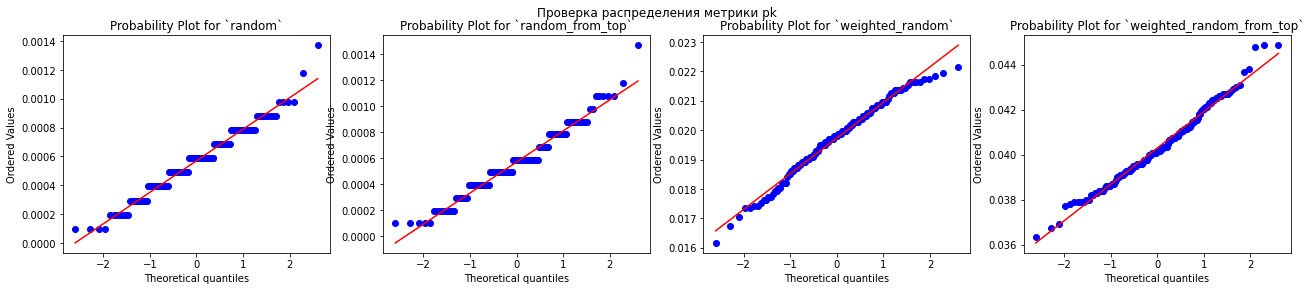

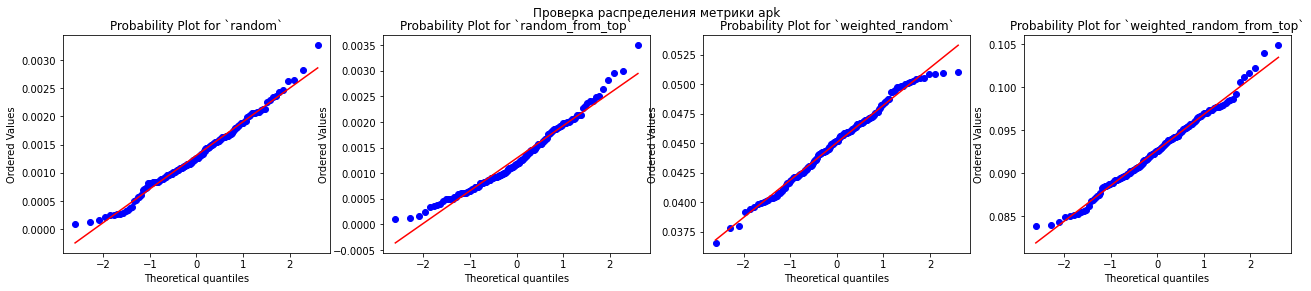

In [280]:
for key, values in metrics.items():
    fig, ax = plt.subplots(1, len(active_columns), figsize=(22, 4))
    fig.suptitle(f'Проверка распределения метрики {key}')
    for i in range(metrics[key].shape[1]):
        st.probplot(metrics[key].T[i], dist='norm', plot=ax[i])
        ax[i].set_title(f'{ax[i].get_title()} for `{active_columns[i]}`')

In [281]:
criteria = []

for key, values in metrics.items():
    m_basic = metrics[key].mean(axis=0)[0::2]
    m_from_top = metrics[key].mean(axis=0)[1::2]
    t = (m_from_top - m_basic) * np.sqrt(N) / metrics[key].std(ddof=1, axis=0)[0::2]
    criteria.append(t)

criteria = np.array(criteria)
criteria

array([[ 7.28454308e-02,  2.08274460e+02],
       [-3.45040411e-01,  1.84978448e+02]])

In [282]:
t0R = st.t.isf(alpha, N - 1)
pd.DataFrame(criteria >= t0R, index=['p@k', 'ap@k'], columns=['clean', 'weighted'])

,clean,weighted
p@k,False,True
ap@k,False,True


Значение `True` говорит в пользу принятия альтернативной гипотезы: в указанном случае предсказание из топ5000 дает статистически подтвержденный прирост метрики на уровне значимости `0.05`.